In [11]:
import pandas as pd
import numpy as np

from datetime import datetime
from models.MainModel import MainModel
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [12]:
def setSeed(seed):
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    else:
        torch.manual_seed(seed)


def getVocabulary(filePath):
    vocabulary = {}
    with open(filePath, 'r') as file:
        for line in file.readlines():
            line = line.replace('\n', '')
            [token, tokenID] = line.split(': ')
            tokenID = int(tokenID)

            vocabulary[token] = tokenID
    return len(vocabulary)


# 读取标签数据
def getLabels(filePath, d):
    nurseIndexes = []
    patientIndexes = []
    scoreList = []
    with open(filePath, 'r') as f:
        for line in f.readlines():
            line = line.replace('\n', '')
            [nurse2Patient, score] = line.split(': ')

            [nurse, patient] = nurse2Patient.split('-')
            score = float(score)

            nurseIndex = int(nurse)
            patientIndex = int(patient)

            nurseIndexes.append(nurseIndex)
            patientIndexes.append(patientIndex)
            scoreList.append(score)

    indexData = torch.tensor(np.row_stack((nurseIndexes, patientIndexes)), dtype=torch.long, device=d)
    scoreData = torch.tensor(np.array(scoreList), dtype=torch.float, device=d)

    return indexData, scoreData


def getEdges(filePath, d):
    srcIds, tarIds = [], []
    with open(filePath, 'r') as f:
        for line in f.readlines()[:-1]:
            line = line.replace('\n', '')
            [srcNode, tarNodes] = line.split(': ')

            srcNode = int(srcNode)
            tarNodes = map(int, tarNodes.split(', '))

            for tarNode in tarNodes:
                srcIds.append(srcNode)
                tarIds.append(tarNode)

    return torch.tensor(np.row_stack((srcIds, tarIds)), dtype=torch.long, device=d)


def lossFunc(nurseVector, patientVector, scoreVector):
    inner_product = (nurseVector * patientVector).sum(dim=-1, keepdims=True)
    log_sigmoid = nn.LogSigmoid()
    return -torch.mean(scoreVector * log_sigmoid(inner_product))

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

In [14]:
nurseData_train = pd.read_csv('../../data/inductive/train/nurseData.csv')
patientData_train = pd.read_csv('../../data/inductive/train/patientData.csv')

nurseData_val = pd.read_csv('../../data/inductive/val/nurseData.csv')
patientData_val = pd.read_csv('../../data/inductive/val/patientData.csv')

In [15]:
tokenCount = getVocabulary('../../data/token2Id.txt')

In [16]:
# 标签数据
indexData_train, scoreData_train = getLabels('../../data/inductive/train/labels.txt', device)
indexData_val, scoreData_val = getLabels('../../data/inductive/val/labels.txt', device)

In [17]:
"""
离散型、连续型特征分类
"""
columnToken_common = ['性别', '省', '民族', '宗教信仰', '学历', '体型']
columnToken_nurse = ['常驻医院', '主要负责病区', '其他负责病区']
columnToken_patient = ['过敏史', '是否残疾', '暴露史', '是否吸烟', '是否饮酒', '常饮酒类', '所属医院', '所在病区']

columnNumber_common = ['年龄', '身高', '体重', 'BMI指数']
columnNumber_nurse = ['普通话程度', '方言程度', '在岗时间', '擅长科室种类', '接单数', '活跃度', '评分']
columnNumber_patient = ['烟龄', '平均每日吸烟次数', '平均每日饮酒次数', '锻炼频率', '刷牙频率', '重症等级']

nurseColumns = columnNumber_common + columnNumber_nurse + columnToken_common + columnToken_nurse
patientColumns = columnNumber_common + columnNumber_patient + columnToken_common + columnToken_patient

nurseData_token_train = torch.tensor(nurseData_train[columnToken_common + columnToken_nurse].values, dtype=torch.long, device=device)
nurseData_number_train = torch.tensor(nurseData_train[columnNumber_common + columnNumber_nurse].values, dtype=torch.float, device=device)

patientData_token_train = torch.tensor(patientData_train[columnToken_common + columnToken_patient].values, dtype=torch.long, device=device)
patientData_number_train = torch.tensor(patientData_train[columnNumber_common + columnNumber_patient].values, dtype=torch.float, device=device)

nurseData_token_val = torch.tensor(nurseData_val[columnToken_common + columnToken_nurse].values, dtype=torch.long, device=device)
nurseData_number_val = torch.tensor(nurseData_val[columnNumber_common + columnNumber_nurse].values, dtype=torch.float, device=device)

patientData_token_val = torch.tensor(patientData_val[columnToken_common + columnToken_patient].values, dtype=torch.long, device=device)
patientData_number_val = torch.tensor(patientData_val[columnNumber_common + columnNumber_patient].values, dtype=torch.float, device=device)

In [18]:
# 获取边数据
edgeDatas_train, edgeDatas_val = [], []
k = 0.9
while k >= 0.5:
    edgeDatas_nurse_train = getEdges(f'../../data/inductive/train/edge_nurse_{round(k, 1)}.txt', device)
    edgeDatas_patient_train = getEdges(f'../../data/inductive/train/edge_patient_{round(k, 1)}.txt', device)

    edgeDatas_train.append((edgeDatas_nurse_train, edgeDatas_patient_train))

    edgeDatas_nurse_val = getEdges(f'../../data/inductive/val/edge_nurse_{round(k, 1)}.txt', device)
    edgeDatas_patient_val = getEdges(f'../../data/inductive/val/edge_patient_{round(k, 1)}.txt', device)

    edgeDatas_val.append((edgeDatas_nurse_val, edgeDatas_patient_val))

    k -= 0.1

In [19]:
nurse_HAT_config = {
    'num_HAT_layers': 3,
    'in_features': [8, 16, 16],
    'out_features': [16, 16, 32],
    'num_softmax_layers': [5, 3, 1],
    'all_dims': [len(nurseColumns), 5, 3],
    'softmax_dims': [
        [[0, 1, 2, 3, 11, 12, 13, 14, 15, 16], [0, 3, 16], [4, 5], [6, 7, 8, 9, 10, 15], [17, 18, 19]],
        [[0], [1, 2, 3], [4]],
        [[0, 1, 2]]
    ]
}

patient_HAT_config = {
    'num_HAT_layers': 3,
    'in_features': [8, 16, 16],
    'out_features': [16, 16, 32],
    'num_softmax_layers': [5, 3, 1],
    'all_dims': [len(patientColumns), 5, 3],
    'softmax_dims': [
        [[0, 1, 2, 3, 10, 11, 12, 13, 14, 15], [0, 3, 9, 15, 17], [16, 18], [4, 5, 6, 7, 8, 19, 20, 21], [22, 23]],
        [[0], [1, 2, 3], [4]],
        [[0, 1, 2]]
    ]
}

GAT_config = {
    'num_of_layers': 2,
    'num_heads_per_layer': [8, 1],
    'num_features_per_layer': [96, 8, 8],
    'dropout_prob': 0.6,
    'bias': True,
    'add_skip_connection': False
}

In [20]:
losses_val = []
epochs, MAX_PATIENCE_CNT = 10000, 1000

for k in range(len(edgeDatas_train)):
    setSeed(2024)
    model = MainModel(
        nurseModel_config={
            'emb_config': {
                'n_count': nurseData_number_train.shape[1],
                't_count': tokenCount,
                'embedded_size': 8
            },
            'useHAT': True,
            'hat_config': nurse_HAT_config,
            'useGAT': True,
            'gat_config': GAT_config
        },
        patientModel_config={
            'emb_config': {
                'n_count': patientData_number_train.shape[1],
                't_count': tokenCount,
                'embedded_size': 8
            },
            'useHAT': True,
            'hat_config': patient_HAT_config,
            'useGAT': True,
            'gat_config': GAT_config
        },
        mlp_config={
            'input_features': 96 + 96,
            'hidden_features': 32,
        }
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=5e-4)
    criterion = nn.L1Loss()

    BEST_VAL_LOSS, PATIENCE_CNT = 5, 0
    lossValues_val = []

    for epoch in range(1, epochs + 1):
        model.train()
        outputs_train = model((nurseData_number_train, nurseData_token_train, edgeDatas_train[k][0]),
                              (patientData_number_train, patientData_token_train, edgeDatas_train[k][1]), indexData_train)
        # loss_train = criterion(outputs_train, scoreData_train.view(-1, 1))
        loss_train = lossFunc(outputs_train[0], outputs_train[1], scoreData_train.view(-1, 1))
        lossValue_train = loss_train.item()

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        with torch.no_grad():
            model.eval()
            outputs_val = model((nurseData_number_val, nurseData_token_val, edgeDatas_val[k][0]),
                                (patientData_number_val, patientData_token_val, edgeDatas_val[k][1]), indexData_val)
            # loss_val = criterion(outputs_val, scoreData_val.view(-1, 1))
            loss_val = lossFunc(outputs_val[0], outputs_val[1], scoreData_val.view(-1, 1))
            lossValue_val = loss_val.item()

            if lossValue_val < BEST_VAL_LOSS:
                # torch.save(model.state_dict(), f'outputs/models/bestModel{i + 1}_{time}.pth')
                BEST_VAL_LOSS = lossValue_val
                PATIENCE_CNT = 0
            else:
                PATIENCE_CNT += 1

        if epoch % 100 == 0:
            print(
                f'Epoch [{epoch}/{epochs}], Train Loss: {lossValue_train*1000:.4f}, Val Loss: {lossValue_val*1000:.4f}, Best Val Loss: {BEST_VAL_LOSS*1000}')

        lossValues_val.append(lossValue_val)

        if PATIENCE_CNT >= MAX_PATIENCE_CNT:
            break

    losses_val.append(lossValues_val)
    print()

Epoch [100/10000], Train Loss: 21.1045, Val Loss: 47.5383, Best Val Loss: 47.53832519054413
Epoch [200/10000], Train Loss: 7.8530, Val Loss: 22.9585, Best Val Loss: 22.958548739552498
Epoch [300/10000], Train Loss: 3.2822, Val Loss: 11.6807, Best Val Loss: 11.680733412504196
Epoch [400/10000], Train Loss: 2.0629, Val Loss: 6.6162, Best Val Loss: 6.61621056497097
Epoch [500/10000], Train Loss: 1.5306, Val Loss: 4.1265, Best Val Loss: 4.126470535993576
Epoch [600/10000], Train Loss: 1.3218, Val Loss: 2.8320, Best Val Loss: 2.8319871053099632
Epoch [700/10000], Train Loss: 0.8938, Val Loss: 2.1175, Best Val Loss: 2.1174598950892687
Epoch [800/10000], Train Loss: 0.7890, Val Loss: 1.7095, Best Val Loss: 1.7095096409320831
Epoch [900/10000], Train Loss: 0.7083, Val Loss: 1.4367, Best Val Loss: 1.4366660034283996
Epoch [1000/10000], Train Loss: 0.5998, Val Loss: 1.2707, Best Val Loss: 1.270717242732644
Epoch [1100/10000], Train Loss: 0.5353, Val Loss: 1.1500, Best Val Loss: 1.149959396570921

In [35]:
for i in range(len(losses_val)):
    losses_val[i] = [num / 100000 for num in losses_val[i]]

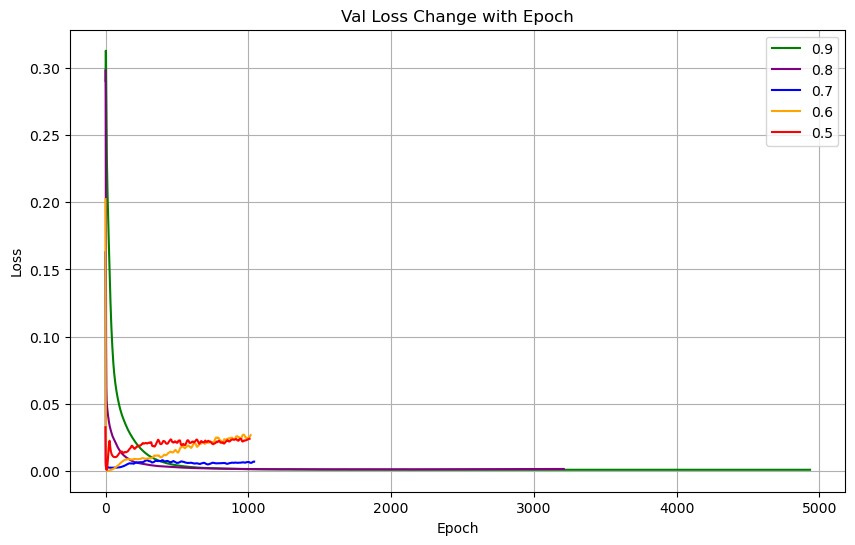

In [38]:
# 创建折线图
plt.figure(figsize=(10, 6))  # 设置图形大小

colors = ['green', 'purple', 'blue', 'orange', 'red']
labels = ['0.9', '0.8', '0.7', '0.6', '0.5']

for i in range(len(edgeDatas_train)):
    # if i == 0:
    #     index = 2
    # elif i == 1:
    #     index = 0
    # elif i == 2:
    #     index = 3
    # elif i == 3:
    #     index = 1
    # else:
    #     index = 4
    # plt.plot(losses_val[index][:500], color=colors[i], linestyle='-', label=labels[i])
    plt.plot(losses_val[i], color=colors[i], linestyle='-', label=labels[i])

plt.title('Val Loss Change with Epoch')  # 设置标题
plt.xlabel('Epoch')  # 设置x轴标签
plt.ylabel('Loss')  # 设置y轴标签
plt.legend()  # 显示图例
plt.grid(True)  # 显示网格线


plt.savefig(f'k_lab_2.png')
plt.show()  # 显示图形